# Spectrum Processing and Model Testing

##### This notebook is designed to be used to load in the files of interest to test the model. The first code block will utilize hyperspy to load in the 3D dataset as well as custom functions to remove calculation errors from the Hyperspectral Optical Microscope (HOM). Afterwards, Savitzky-Golay filtering was used to reduce the noise in the spectrum to more accurately mimic the synthetically generated data.

#### This notebook can also be used to test the trained model on real, processed data, and output the metrics of merit to determine the success of the model.

# Spectrum Processing

In [ ]:
import hyperspy.api as hs
import hyperspy.signal_tools as hs_st
import hyperspy.axes as axes
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Ground_Truth_Creator import getGT
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os

In [ ]:
def loadFiles(title, size_arr, size_sel):
    """
    Function to load the files and crop them to the correct size.

    Args:
        title: The title of the file to be loaded
        size_arr: The array containing the size of the crop
        size_sel: The index of the size
    Returns:
        s0.data: 3D Hyperspy data array of size (300, 300, n_wavelengths)
    """
    s0 = hs.load(title) # Load the file
    s0.data = s0.data[::-1] # The file needs to be transposed to solve an issue with the array dimensions.

    s0.crop(1,size_arr[size_sel][0][0], size_arr[size_sel][0][1])
    s0.crop(2,size_arr[size_sel][1][0], size_arr[size_sel][1][1])

    # set titles and name variables.
    s0 = s0.as_signal1D(0)
    s0.axes_manager[0].name = "width"
    s0.axes_manager[1].name = "height"
    s0.axes_manager[2].name = "wavelength"
    s0.axes_manager[0].units = "pix"
    s0.axes_manager[1].units = "pix"
    s0.axes_manager[2].units = "nm"
    s0.axes_manager[2].offset = 200
    s0.axes_manager[2].scale = 4

    return s0.data

def removeIssuePoint1(data):
    """
    First function to remove miscalculation error from HOM if the dataset
    contains less than 151 points on the wavelength axis.

    Args:
        data: The data array to be processed (len)
    Returns:
        data: The data array after correcting the miscalculation (len)
    """
    for x in range(len(data)):
        for y in range(len(data[0])):
            curMax = np.max(data[x][y])
            for z in range(len(data[0][0])):
                if data[x][y][z] == curMax:
                    data[x][y][z] = data[x][y][z-1] # Replace the miscalculation with the previous value
                    break
    return data

def removeIssuePoint2(data):
    """
    Second function to remove miscalculation error from HOM if the dataset
    contains more than 151 points on the wavelength axis.

    Args:
        data: The data array to be processed (len)
    Returns:
        data: The data array after correcting the miscalculation (len - 1)
    """
    for x in range(len(data)):
        for y in range(len(data[0])):
            curMax = np.max(data[x][y])
            for z in range(len(data[0][0])):
                if data[x][y][z] == curMax:
                    index = z
                    break
            break
        break
    data = np.delete(data, index, 2) # Delete the miscalculation for dataset
    return data

def removeIssuePoint3(data):
    """
    Function to ensure the length of the final array is 150 along the wavelength axis.

    Args:
        data: The data array to be processed (len > 150)
    Returns:
        data: The data array after correcting the miscalculation (len = 150)
    """
    while len(data[0][0]) > 150:
        data = np.delete(data, -1, 2)
    return data

def subtract_background(data):
    """
    Subtract the background signal from the DRS data. Use the first 20 and last 20
    points of the spectrum to calculate the background signal.

    Args:
        data: The data array to be processed
    Returns:
        data: Background subtracted data array of the same length
    """
    limits = np.arange(len(data[0][0]))
    for x in range(len(data)):
        for y in range(len(data[0])):
            background_indices = np.concatenate((np.arange(20), np.arange(-20, 0)))  # Indices for the background points
            background_x = limits[background_indices]
            background_y = data[x][y][background_indices]
            background_params = np.polyfit(background_x, background_y, 1)  # Fit a line
            background = np.polyval(background_params, limits)
            data[x][y] = data[x][y] - background
    return data

def SGprocess(data):
    """
    Function to process the data using the Savitzky-Golay filter of window size = 5
    and polynomial order = 5.

    Args:
        data: The data array to be processed
    Returns:
        standard_SG: Savitzky-Golay processed data array reshaped into original dimensions (n_x, n_y, n_wavelengths)
    """
    data = data.reshape(90000, 150)
    standard_SG = savgol_filter(data, 50, 5, mode='constant') # Apply the Savitzky-Golay filter with constant mode to ensure wavelength axis is not altered
    return standard_SG.reshape(300, 300, 150)

def load_and_process_data(file, size_arr, size_sel):
    """
    Function to load and pre-process the data array from the original filename.

    Args:
        file: The filename of the data to be processed
    Returns:
        final_data: The final processed data array
    """
    data = loadFiles(file, size_arr, size_sel)
    if len(data[0][0]) < 151:
        final_data = SGprocess(subtract_background(removeIssuePoint1(data)))
    elif len(data[0][0]) > 151:
        final_data = SGprocess(subtract_background(removeIssuePoint3(removeIssuePoint2(data))))
    else:
        final_data = SGprocess(subtract_background(removeIssuePoint2(data)))
    return final_data

# Global variables to find triangle of interest from full image
size_sel_gb = 1
size_arr_gb = [[[345 ,350], [810, 815]], [[216, 516], [675, 975]], [[222, 495], [672, 972]]]

# Define the folder path
folder_path = 'Time Series Oxidation Files'
full_path = os.path.join(os.getcwd(), folder_path)

data_list = []

# Non pre-processed data
example_file = os.path.join(full_path, "00minUVO_WS2_550-700_1nmsteps_150ms-1 (1).tif")
example_spectrum = subtract_background(loadFiles(example_file, size_arr_gb, size_sel_gb))

# Load in all pre-processed data
for file in os.listdir(full_path):
    if file.endswith('.tif'):
        print(file)
        file_path = os.path.join(full_path, file)
        data_list.append(load_and_process_data(file_path, size_arr_gb, size_sel_gb))

# Use GT function to get the ground truth classification result
ground_truth_list = []
for item in os.listdir(full_path):
    if item.endswith('.tif'):
        file_path = os.path.join(full_path, item)
        ground_truth_list.append(getGT(file_path))

In [8]:
# Use GT function to get the ground truth classification result
ground_truth_list = []
for item in os.listdir(full_path):
    if item.endswith('.tif'):
        file_path = os.path.join(full_path, item)
        ground_truth_list.append(getGT(file_path))

# Visualize Spectrum

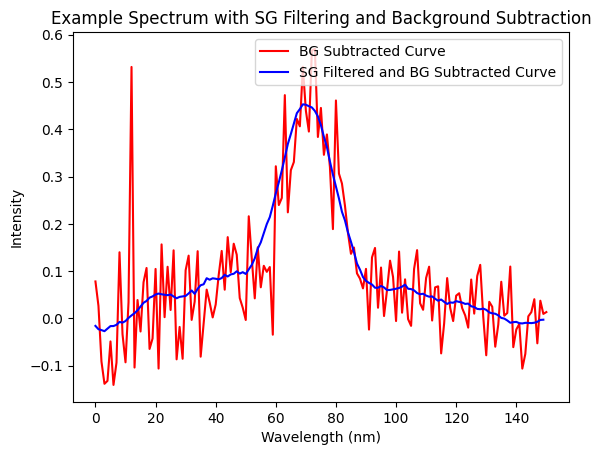

In [19]:
x, y = 150,150
plt.plot(example_spectrum[y][x], c='red', label='BG Subtracted Curve')
plt.plot(data_list[0][y][x], c='blue', label='SG Filtered and BG Subtracted Curve')
plt.title("Example Spectrum with SG Filtering and Background Subtraction")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

# Testing the Model

In [12]:
def visualizeModel(data, classification_threshold = 0.995):
    """"
    Function to visualize the model output for a given dataset

    Args:
        model: The trained model to be used for inference
        data: The dataset to be used for inference
        classification_threshold: The threshold for classification
    Returns:
        material_mask: The binary material mask containing the classification results
        dopant_map: The dopant map containing the regression results
    """
    assert(len(data[0][0]) == 150)
    Y_sel, X_sel, W_sel = data.shape

    # Flatten spatial dimension for inference
    X_input = data.reshape((Y_sel * X_sel, W_sel))
    X_input = X_input[..., np.newaxis]

    classification_pred, regression_pred = model.predict(X_input, batch_size=32)
    classification_map = classification_pred.reshape((Y_sel, X_sel))
    dopant_map = regression_pred.reshape((Y_sel, X_sel))

    material_mask = (classification_map > classification_threshold).astype(float)
    dopant_map[material_mask == 0] = np.nan

    return material_mask, dopant_map

classification_results = []
regression_results = []
counter = 0

# Load in the trained model
model = tf.keras.models.load_model('Oxidation_Model/Ox_Class_Model.h5')

for data in data_list:
    print(f"File Number {counter}")
    model_result = visualizeModel(data)
    classification_results.append(model_result[0])
    regression_results.append(model_result[1])
    counter += 1

File Number 0
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
File Number 1
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step
File Number 2
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step
File Number 3
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
File Number 4
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step
File Number 5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
File Number 6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
File Number 7
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
File Number 8
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
File Number 9
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
File Number 10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
File Number 11
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step
File Number 12
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
File Number 13
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step
File Number 14
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step
File Number 15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step


# Visualize Results

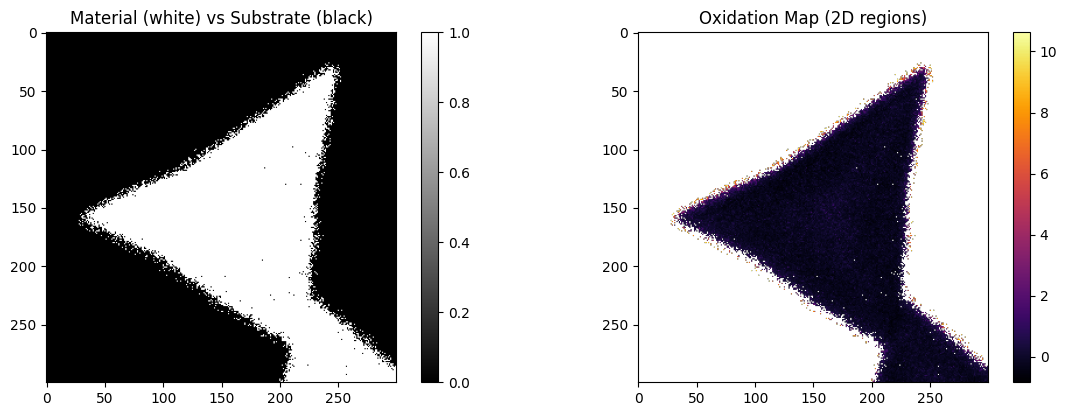

Example Oxidation Percentage: -0.09793877601623535
Example Classification (1): 1.0
Example Classification (0): 0.0


In [13]:
time_step = 0
plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plt.imshow(classification_results[time_step], cmap='gray')
plt.title('Material (white) vs Substrate (black)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(regression_results[time_step], cmap='inferno')
plt.title('Oxidation Map (2D regions)')
plt.colorbar()

plt.show()

print(f"Example Oxidation Percentage: {regression_results[time_step][150][150]}")
print(f"Example Classification (1): {classification_results[time_step][150][150]}")
print(f"Example Classification (0): {classification_results[time_step][0][0]}")

# Model Evaluation

### Classification Results

In [14]:
def getAccuracyScore(Prediction, gt_Data):
    """
    Function to calculate the accuracy score of the model

    Args:
        Prediction: The predicted data
        gt_Data: The ground truth data
    Returns:
        correct / len(gt_Data): The accuracy score
    """
    Prediction = Prediction.flatten()
    assert(len(gt_Data) == len(Prediction))
    correct = 0
    for i in range(len(gt_Data)):
        if gt_Data[i] == Prediction[i]:
            correct += 1
    return correct / len(gt_Data)

accuracy_scores = []
for i in range(len(classification_results)):
    accuracy_scores.append(getAccuracyScore(classification_results[i], ground_truth_list[i]))

print(np.round(accuracy_scores, 4))

[0.9623 0.9698 0.8977 0.9464 0.8601 0.9479 0.9484 0.9289 0.92   0.8985
 0.874  0.8526 0.8288 0.7884 0.7728 0.7465]


### Regression Results

In [15]:
def getMedian(oxidation_map):
    """
    Function to calculate the median of the oxidation map

    Args:
        oxidation_map: The oxidation map to be used
    Returns:
        np.median(clean_map): The median of the oxidation map
    """
    oxidation_map = oxidation_map.flatten()
    clean_map = oxidation_map[~np.isnan(oxidation_map)]
    return np.median(clean_map)

medianVals = []
for time in regression_results:
    medianVals.append(getMedian(time))

print(np.round(medianVals, 4))

[-0.1673  1.3378  1.9646  2.8383  2.7496  2.2057  2.9005  3.6911  3.9757
  4.3975  5.7022  6.1692  6.583   7.5419  7.6781  8.2872]


R² value: 0.9544
RMSE: 3.98
MAE: 3.3013


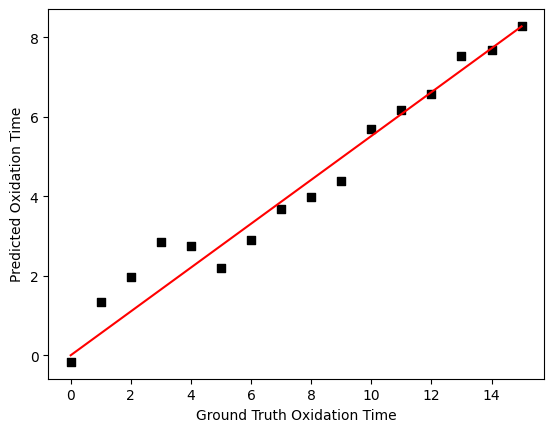

In [16]:
y0 = np.float32(0)
x = np.arange(0, 16, 1)
slope, _, _, _ = np.linalg.lstsq(x[:, np.newaxis], medianVals - y0, rcond=None)
y_fit = y0 + slope * x

# Calculate R-squared
y_mean = np.mean(medianVals)
ss_tot = np.sum((medianVals - y_mean) ** 2)
ss_res = np.sum((medianVals - y_fit) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R² value: {r_squared:.4f}")
RMSE = root_mean_squared_error(x, medianVals)
MAE = mean_absolute_error(x, medianVals)
print(f"RMSE: {np.round(RMSE, 4)}")
print(f"MAE: {np.round(MAE, 4)}")

# Plot the fitted line with R² in legend
plt.plot(x, y_fit, label=f'Fitted Line (R² = {r_squared:.4f})', color='red')
plt.scatter(x, medianVals, c='black', marker='s', )
plt.xlabel('Ground Truth Oxidation Time')
plt.ylabel('Predicted Oxidation Time')
plt.show()